In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [4]:
import tensorflow as tf
from tensorflow_graph_in_jupyter import show_graph

/Users/Toshiaki/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# MNIST training session

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [6]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [7]:
n_epochs = 40
batch_size = 50

In [8]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [10]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits)

In [11]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    # to record logs, add this code below
    loss_summary = tf.summary.scalar('log_loss', loss)

In [12]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [13]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    # to record logs, add this code below
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [14]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [15]:
n_epochs = 20
n_batches = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.9 Validation accuracy: 0.9024
1 Batch accuracy: 0.92 Validation accuracy: 0.9254
2 Batch accuracy: 0.94 Validation accuracy: 0.9372
3 Batch accuracy: 0.9 Validation accuracy: 0.9416
4 Batch accuracy: 0.94 Validation accuracy: 0.9472
5 Batch accuracy: 0.94 Validation accuracy: 0.9512
6 Batch accuracy: 1.0 Validation accuracy: 0.9548
7 Batch accuracy: 0.94 Validation accuracy: 0.961
8 Batch accuracy: 0.96 Validation accuracy: 0.9622
9 Batch accuracy: 0.94 Validation accuracy: 0.9648
10 Batch accuracy: 0.92 Validation accuracy: 0.9656
11 Batch accuracy: 0.98 Validation accuracy: 0.9666
12 Batch accuracy: 0.98 Validation accuracy: 0.9684
13 Batch accuracy: 0.98 Validation accuracy: 0.9704
14 Batch accuracy: 1.0 Validation accuracy: 0.9694
15 Batch accuracy: 0.94 Validation accuracy: 0.9718
16 Batch accuracy: 0.98 Validation accuracy: 0.9726
17 Batch accuracy: 1.0 Validation accuracy: 0.9728
18 Batch accuracy: 0.98 Validation accuracy: 0.9744
19 Batch accuracy: 0.98 Vali

In [29]:
show_graph(tf.get_default_graph())

# prediction session

In [17]:
svaer = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [18]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:20])

Predicted classes: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


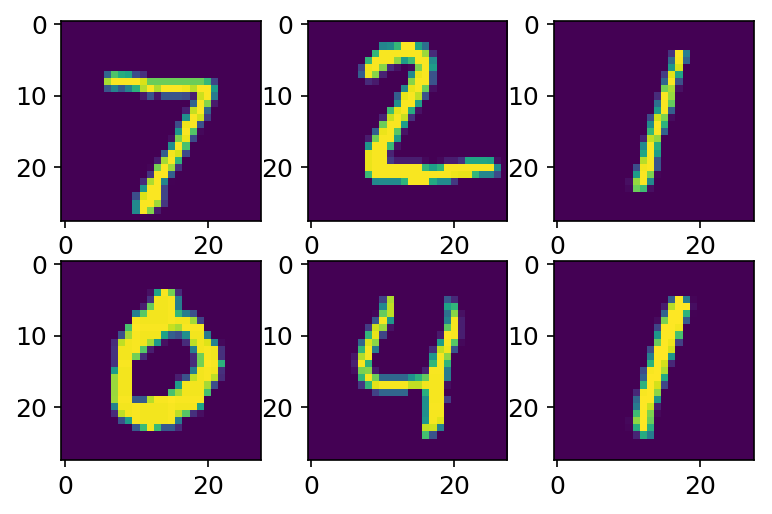

In [28]:
fig = plt.figure(figsize=(6, 6),dpi=150)
for i in range(1,7):
    ax = fig.add_subplot(3,3,i)
    ax.imshow(X_test[i-1].reshape(28,28))


# MNIST training session, hidden layers are 5

In [48]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [49]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [50]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_hidden3 = 50

n_outputs = 10

In [51]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [52]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden1, name="hidden2",
                              activation=tf.nn.relu)
    hidden3 = tf.layers.dense(hidden2, n_hidden2, name="hidden3",
                              activation=tf.nn.relu)
    hidden4 = tf.layers.dense(hidden3, n_hidden2, name="hidden4",
                              activation=tf.nn.relu)
    hidden5 = tf.layers.dense(hidden4, n_hidden3, name="hidden5",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits)
    
with tf.name_scope("loss"):
    # calculate softmax and calculate cross_entropy 
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    # to record logs, add this code below
    loss_summary = tf.summary.scalar('log_loss', loss)
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) # 普通に平均
    # to record logs, add this code below
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [53]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 30
n_batches = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.92 Validation accuracy: 0.8924
1 Batch accuracy: 0.92 Validation accuracy: 0.936
2 Batch accuracy: 0.96 Validation accuracy: 0.9494
3 Batch accuracy: 0.92 Validation accuracy: 0.9546
4 Batch accuracy: 0.98 Validation accuracy: 0.9602
5 Batch accuracy: 0.98 Validation accuracy: 0.959
6 Batch accuracy: 1.0 Validation accuracy: 0.968
7 Batch accuracy: 1.0 Validation accuracy: 0.9684
8 Batch accuracy: 1.0 Validation accuracy: 0.9714
9 Batch accuracy: 0.96 Validation accuracy: 0.9732
10 Batch accuracy: 0.98 Validation accuracy: 0.9704
11 Batch accuracy: 1.0 Validation accuracy: 0.975
12 Batch accuracy: 0.98 Validation accuracy: 0.9708
13 Batch accuracy: 1.0 Validation accuracy: 0.9748
14 Batch accuracy: 1.0 Validation accuracy: 0.976
15 Batch accuracy: 1.0 Validation accuracy: 0.976
16 Batch accuracy: 1.0 Validation accuracy: 0.9776
17 Batch accuracy: 1.0 Validation accuracy: 0.9784
18 Batch accuracy: 1.0 Validation accuracy: 0.9794
19 Batch accuracy: 1.0 Validation accu

In [54]:
show_graph(tf.get_default_graph())